In [0]:
!pip install torchaudio

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import warnings

import torchaudio
from torch.utils.data import Dataset
from torchaudio.datasets.utils import download_url, extract_archive, walk_files

from ast import literal_eval
from pathlib import Path

import pandas as pd

import torchaudio
import torch
import fastai
import fastai.vision
from fastai.basics import *
from torchvision import transforms
import matplotlib.pyplot as plt

In [0]:


data_path = Path('/content/drive/My Drive/deepSync/data')

class AirbudDataset(Dataset):
    """
    Create a Dataset for Audio. Each item is a tuple of the form:
    (waveform, sample_rate, labels)
    """

    def __init__(
        self,
        root,
        data_path=data_path,
        anim_csv='data2.csv',
        audio_ext='.aif',
        download=False,
        transform=None,
        target_transform=None,
    ):

        self.transform = transform
        self.target_transform = target_transform

        self._audio_path = root/data_path/Path('Audio')
        self._anim_path = root/data_path/Path(anim_csv)
        self._ext_audio = audio_ext

        if not os.path.isdir(self._audio_path):
            raise RuntimeError(
                "Dataset not found. Please use `download=True` to download it."
            )

        self.df = self._process_df(pd.read_csv(self._anim_path))

        walker = walk_files(
            self._audio_path, suffix=self._ext_audio, prefix=False, remove_suffix=True
        )

        # self._walker = list(walker)
        self._walker = [x for x in list(walker) if len(self.df[self.df['Audio File'].str.contains(x)]['jawTrans_ty']) > 0]
        

    def _process_df(self, df):
        def convert_to_list(x):
          try:
              y = literal_eval(x)
              return y
          except:
              return x
        
        def convert_floats(x):
            if isinstance(x, float):
                return [x]
            else:
                return x

        df['jawTrans_ty'] = df['jawTrans_ty'].fillna('0.0')
        df['jawTrans_ty'] = df['jawTrans_ty'].apply(lambda x: convert_to_list(x))
        df['jawTrans_ty'] = df['jawTrans_ty'].apply(lambda x: convert_floats(x))
        return df

    def _get_labels(self, fileid):
        y_vals = self.df[self.df['Audio File'].str.contains(fileid)]['jawTrans_ty'].values[0]
        return y_vals


    def _load_audio_item(self, fileid):
        # Read label
        labels = self._get_labels(fileid)

        # Read audio
        filepath = str(self._audio_path / Path(fileid)) + self._ext_audio

        waveform, sample_rate = torchaudio.load(filepath)

        return waveform, sample_rate, labels



    def __getitem__(self, n):
        fileid = self._walker[n]
        item = self._load_audio_item(fileid)

        waveform, sample_rate, labels = item
        
        labels = torch.Tensor(labels).unsqueeze(dim=0)
        
        if self.transform is not None:
            waveform = self.transform(waveform)
        if self.target_transform is not None:
            labels = self.target_transform(labels)

        return waveform, labels

    def __len__(self):
        return len(self._walker)

In [0]:
class PadTrim(object):
    """Pad/Trim a 1d-Tensor (Signal or Labels)
    Args:
        tensor (Tensor): Tensor of audio of size (n x c) or (c x n)
        max_len (int): Length to which the tensor will be padded
        channels_first (bool): Pad for channels first tensors.  Default: `True`
    """

    def __init__(self, max_len, fill_value=0, channels_first=True):
        self.max_len = max_len
        self.fill_value = fill_value
        self.len_dim, self.ch_dim = int(channels_first), int(not channels_first)

    def __call__(self, tensor):
        """
        Returns:
            Tensor: (c x n) or (n x c)
        """
        assert tensor.size(self.ch_dim) < 128, \
            "Too many channels ({}) detected, see channels_first param.".format(tensor.size(self.ch_dim))
        if self.max_len > tensor.size(self.len_dim):
            padding = [self.max_len - tensor.size(self.len_dim)
                       if (i % 2 == 1) and (i // 2 != self.len_dim)
                       else 0
                       for i in range(4)]
            with torch.no_grad():
                tensor = torch.nn.functional.pad(tensor, padding, "constant", self.fill_value)
        elif self.max_len < tensor.size(self.len_dim):
            tensor = tensor.narrow(self.len_dim, 0, self.max_len)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(max_len={0})'.format(self.max_len)


In [0]:
from torchvision import transforms
import torch 
transform = transforms.Compose([
                                PadTrim(480000),
                                # torchaudio.transforms.Spectrogram(n_fft=800, win_length=None, hop_length=None, pad=0, power=2, normalized=False),
                                torchaudio.transforms.MelSpectrogram(sample_rate=48000, n_fft=2000, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=10, n_mels=128),
                                transforms.ToPILImage(),
                                transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                ]
                               )

target_transform = transforms.Compose([
                                PadTrim(240, channels_first=True)
                                ]
                               )

In [0]:
root = Path('/content/drive/My Drive/deepSync')
dataset = AirbudDataset(root, transform=transform, target_transform=target_transform)
dummy_ds = AirbudDataset(root)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (437,438,439,440,442,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,474,476,482,488,489,490,494,495,496,497,498,499,500,501,502,506,507,511,524,525,529,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [0]:
idx = 1
dataset[idx][0].shape, dataset[idx][1]

(torch.Size([1, 480, 480]),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000, -0.2762, -0.8793, -1.4708, -1.9460, -2.3645, -2.5498,
          -2.0461, -1.3184, -0.9753, -0.7582, -0.5970, -0.5339, -0.9380, -1.5768,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.000

In [0]:
dataset[idx][1].shape

torch.Size([1, 240])

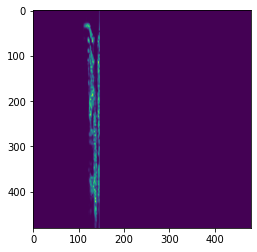

In [0]:
plt.imshow(dataset[idx][0].squeeze())

In [0]:
# from IPython.display import Audio
# af = dummy_ds[idx]
# Audio(data=af[0],rate=af[1])

In [0]:
audio_dataset = AirbudDataset('.', download=True, transform=transform, target_transform=target_transform)
# len(audio_dataset)
train_set, valid_set = torch.utils.data.random_split(audio_dataset, [4000, 533])
train_set.c = 240
valid_set.c = 240

bs = 4

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=bs,
                                          shuffle=True,
                                          num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_set,
                                          batch_size=bs,
                                          shuffle=True,
                                          num_workers=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (437,438,439,440,442,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,474,476,482,488,489,490,494,495,496,497,498,499,500,501,502,506,507,511,524,525,529,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [0]:
idx = 0
audio_dataset[idx][0].shape, audio_dataset[idx][1].shape

(torch.Size([1, 480, 480]), torch.Size([1, 240]))

In [0]:
db = fastai.basic_data.DataBunch(train_loader, valid_loader)

In [0]:
from torch import nn
from functools import partial

criterion = torch.nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

arch = fastai.vision.models.resnet152

# head = nn.Sequential(nn.Linear(8, 8), nn.Sigmoid())

f_beta = partial(fastai.metrics.fbeta, thresh=0.5, sigmoid=True)

learner = fastai.vision.cnn_learner(db, base_arch=arch, pretrained=True, loss_func=criterion)

learner.model[0][0] = nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False).cuda()
learner.model

epoch,train_loss,valid_loss,time


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 1, 240])) that is different to the input size (torch.Size([4, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


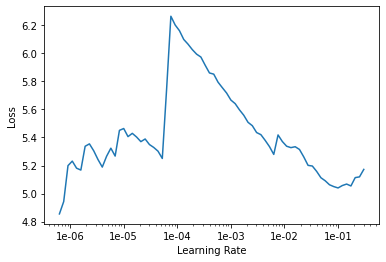

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.save('CNN-stage-0')

In [0]:
learner.load('CNN-stage-0')

In [0]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,1.402443,1.128601,53:04


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 1, 240])) that is different to the input size (torch.Size([4, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 240])) that is different to the input size (torch.Size([1, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,1.564377,1.126548,08:56
1,1.105507,1.120202,08:54
2,1.206186,1.110048,08:53
3,1.021633,1.108713,08:54
4,1.179411,1.109269,08:57


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 1, 240])) that is different to the input size (torch.Size([4, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 240])) that is different to the input size (torch.Size([1, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
learner.save('CNN-stage-1')

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,time


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 1, 240])) that is different to the input size (torch.Size([4, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


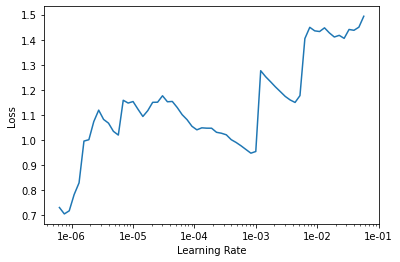

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,1.097089,1.116765,11:42
1,1.134120,1.110853,11:42
2,1.176181,1.109251,11:36
3,1.094763,1.113056,11:28
4,0.980376,1.108008,11:23


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([4, 1, 240])) that is different to the input size (torch.Size([4, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 240])) that is different to the input size (torch.Size([1, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
preds = learner.get_preds()

[tensor([[-2.7426e-01, -2.9477e-01, -3.3395e-01,  ..., -1.0381e-02,
          -4.9118e-03, -7.7882e-03],
         [-2.8422e-01, -3.0487e-01, -3.2117e-01,  ..., -1.2937e-02,
          -2.9208e-03, -1.5133e-02],
         [-2.7466e-01, -3.0623e-01, -3.2603e-01,  ..., -9.4418e-03,
          -1.5483e-02, -1.3479e-02],
         ...,
         [-7.8645e-01, -6.5779e-01, -4.6792e-01,  ..., -2.0399e-02,
          -2.7818e-01, -1.2438e-01],
         [-2.9172e-01, -2.9175e-01, -3.2980e-01,  ..., -1.0059e-02,
          -6.4985e-03,  7.2787e-04],
         [-2.7759e-01, -3.2292e-01, -3.3937e-01,  ..., -1.2831e-02,
          -1.2117e-02, -2.0695e-02]]),
 tensor([[[-0.2323, -0.2323, -0.2323,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         ...,
 
         [[ 0.0000,  0.0000,  0.0464,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000, 

In [0]:
len(preds)

2

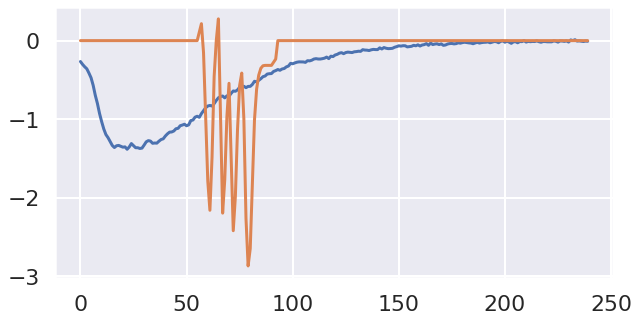

In [0]:
import matplotlib.pyplot as plt
x = preds[0].numpy()
y = preds[1].numpy().squeeze(1)

idx = 5
plt.plot(x[idx])
plt.plot(y[idx])